In [1]:
#importing the needed libraries:
from matplotlib import pyplot as plt
import networkx as nx
import random
import numpy as np
from scipy import stats
import math
import copy

In [2]:
class family_network: # defining a class to generate the network
    def __init__(self, gamma, family_gamma, beta, believers , media ):
        self.graph = nx.watts_strogatz_graph(70, 10, 0.1)  
        self.layout = nx.spring_layout(self.graph)
        self.families_list = [] # all families in the network
        self.gamma = gamma
        self.family_gamma = family_gamma #specific to families edges
        self.beta = beta
        self.believers = believers # setting the opinion of the believers
        self.media = media # setting the opinion for media
        self.media_opinion = None # will be set using the above variable
        self.steps=0 #number of steps after each update
        self.steps_list=[0] #list of the number of steps after each analysis (for plots) 
        
        self.len_similar_nodes_1 =[] #nodes who agree on opinion 1 (opinion that is >0.5)
        self.len_connected_different_nodes =[] #nodes who have different opinion but still have edges
        self.len_connected_different_nodes_edges=[] # their number
        self.len_similar_nodes_2 = [] # nodes who agree on opinion 2 (opinion that is <0.5)
        self.len_connected_similar_nodes_1=[] # edges of nodes who agree on 1
        self.len_connected_similar_nodes_2 =[]# edges of nodes who agree on 2
        self.len_believers_opinion_1 = [] # believers who have opinion 1
        self.len_believers_opinion_2=[] # believers who have opinion 2
        self.non_believers_opinion_1=[] # all other nodes with opinion 1
        self.non_believers_opinion_2 = [] # all other nodes with opinion 2
        self.len_conflicted_families = [] # number of families that at least one of their memebers have 
        # a different opinion
        self.len_non_conflicted_families=[] #number of families that all agree on the same opinion
        #
        


        
    def create_family_network(self): # this will create the families in the network
        norm_dist = stats.norm(loc = 3.19, scale = 1) #normal distribution for the size of families
        familiy_ID = 0 
        for node in self.graph.nodes():
            families_list_flattened = [item for sublist in self.families_list for item in sublist] #using this to
            # make sure that families members don't get repeated in several families
            if node not in families_list_flattened:
                family_number = max(1,math.ceil(norm_dist.rvs(1)[0])) #making sure that the familiy number 
                #is a positive integer
                
                potential_family = np.setdiff1d(list(self.graph.neighbors(node))
                                                , families_list_flattened) # get a list of unique potetnial 
                #family members that don't exist in the other families
                
                local_family = random.sample(list(potential_family), #choose the family randomly
                                             min(family_number,len(list(potential_family)) ))

                local_family.append(node) #node is member of that family
                
                self.families_list.append(local_family)#add this family to my list of families
                familiy_ID+=1 #change the family ID
                for member in local_family:
                    self.graph.nodes[member]['family'] = familiy_ID
        
 
    def initialize(self): #initializing the weights and opinions
        for edge in self.graph.edges:
            #families have a higher weight than other nodes
            if self.graph.nodes[edge[0]]['family'] == self.graph.nodes[edge[1]]['family']:
                self.graph.edges[edge]['weight'] = 0.9
                self.graph.edges[edge]['family'] = True   
            else:
                self.graph.edges[edge]['weight'] = 0.5
                self.graph.edges[edge]['family'] = False
        
        for node in self.graph.nodes: #opinion chosen randomly between 0 and 1
            self.graph.nodes[node]['opinion'] = random.randint(0, 1)
            alpha = random.uniform(0, 0.1) #alpha chosen randomly between 0 and 0.1
            while alpha == 0:
                alpha = random.uniform(0, 0.1)
            self.graph.nodes[node]['alpha'] = alpha #flexibility / stubbornness / strength of belief
            if alpha < 0.005: #believers have alpha less than 0.005
                self.graph.nodes[node]['H'] = True # Believer / persuasive / influencer
            else:
                self.graph.nodes[node]['H'] = False # Believer / persuasive / influencer
            
                
    def set_bias(self ): # this function will set the opinion of believers and media only if it gets
        #called, otherwise they are already set randomly
        if self.believers:
            for node in self.graph.nodes:
                if self.graph.nodes[node]['H']:
                    self.graph.nodes[node]['opinion'] = 1 if self.believers==1 else 0
        
        if self.media:
            self.media_opinion = 1 if self.media==1 else 0
        else:
            self.media_opinion = random.choice([0, 1])

    def observe(self): #observing my graph
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
        plt.clf()
        node_sizes = []
        for node in self.graph.nodes():
            if self.graph.nodes[node]['H']:
                node_sizes.append(1200) #bigger size for believers
            else:
                node_sizes.append(400)
        nx.draw(self.graph, pos =self.layout, 
                node_color=[self.graph.nodes[i]['opinion'] for i in self.graph.nodes],
                edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
                edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
                alpha=0.7, vmin=0, vmax=1, node_size=node_sizes)
        '''
        nx.draw(
            self.graph, pos=self.layout, with_labels=True,
            node_color=[self.graph.nodes[i]['opinion'] for i in self.graph.nodes],
            edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
            alpha=0.7, vmin=0, vmax=1)
        '''
        labels = copy.deepcopy(dict(self.graph.nodes)) #getting family IDs as labels
        for key in labels:
            labels[key] = labels[key]['family']
        nx.draw_networkx_labels(self.graph, pos=self.layout, labels = labels)
        plt.show()

    def get_dict(self): #this dictionary has all information for analysis
        good_dict = copy.deepcopy(dict(self.graph.edges))
        for key in good_dict: #it has opinions, weights, families
            good_dict[key][f"Node {key[0]}'s Opinion"] = self.graph.nodes[key[0]]['opinion']
            good_dict[key][f"Node {key[1]}'s Opinion"] = self.graph.nodes[key[1]]['opinion']
        return good_dict 
    

    def analysis(self): #doing the analysis on the results
        my_dict = self.get_dict()
        similar_nodes_1 = [] # opinion >0.5 
        similar_nodes_2 = [] # opinion < 0.5
        believers_opinion_1 = [] # count the number of believers with opinion 1 at each time step
        believers_opinion_2 = [] # count the number of believers with opinion 2 at each time step
        non_believers_opinion_1 = []# count the number of non-believers with opinion 1 at each time step
        non_believers_opinion_2 = []# count the number of non-believers with opinion 2 at each time step
        for node in self.graph.nodes: 
            if self.graph.nodes[node]['opinion'] >0.5: # this will be opinion 1
                similar_nodes_1.append(node)
            else:
                similar_nodes_2.append(node)
            
            if self.graph.nodes[node]['H'] : #believers
                if self.graph.nodes[node]['opinion'] >0.5:
                    believers_opinion_1.append(node)
                else:
                    believers_opinion_2.append(node)

            else: # non believers
                if self.graph.nodes[node]['opinion'] >0.5:
                    non_believers_opinion_1.append(node)
                else:
                    non_believers_opinion_2.append(node)
                

        # count the number of edges at each time step
        connected_similar_nodes_1 = [] 
        connected_similar_nodes_2 = []
        connected_different_nodes = []
        
        #count edges of similar and different opinion nodes
        for key in my_dict:
            if my_dict[key][f"Node {key[0]}'s Opinion"] > 0.5 and my_dict[key][f"Node {key[1]}'s Opinion"] > 0.5:
                connected_similar_nodes_1.append(key)

            elif my_dict[key][f"Node {key[0]}'s Opinion"] < 0.5 and my_dict[key][f"Node {key[1]}'s Opinion"] < 0.5:
                connected_similar_nodes_2.append(key)
            else:
                connected_different_nodes.append(key)
        
        #count families with and without conflicts 
        conflicted_families = 0
        non_conflicted_families=0
        for family in self.families_list:
            s = [self.graph.nodes[i]['opinion'] for i in family]
            if all(i> .5 for i in s) or all(i< .5 for i in s): #if all have same opinion
                non_conflicted_families+=1
            else:
                conflicted_families+=1

        #update the following attribute lists which will be used for my plots
        self.len_similar_nodes_1.append(len(similar_nodes_1))
        self.len_connected_different_nodes.append(len(set(np.array(connected_different_nodes).flatten())))
        self.len_connected_different_nodes_edges.append(len(connected_different_nodes))
        self.len_similar_nodes_2.append(len(similar_nodes_2))
        self.len_connected_similar_nodes_1.append(len(connected_similar_nodes_1))
        self.len_connected_similar_nodes_2.append(len(connected_similar_nodes_2))
        self.len_believers_opinion_1.append(len(believers_opinion_1))
        self.len_believers_opinion_2.append(len(believers_opinion_2))
        self.non_believers_opinion_1.append(len(non_believers_opinion_1))
        self.non_believers_opinion_2.append(len(non_believers_opinion_2))
        self.len_conflicted_families.append(conflicted_families)
        self.len_non_conflicted_families.append(non_conflicted_families)     
   


    def make_plot(self, plot_name):
        # Using two types of plots: bar and linear
        if plot_name == "bar":
            plt.subplots(1, 2, figsize = (11, 5))
            
            # A bar plot of the number of nodes and their edges
            plt.subplot(1,2, 1)
            x = ["Agree on 1", "Disagree but \n connected","Agree on 2"] 
            y =[self.len_similar_nodes_1[-1], self.len_connected_different_nodes[-1], self.len_similar_nodes_2[-1]]
            z =[self.len_connected_similar_nodes_1[-1], self.len_connected_different_nodes_edges[-1], 
                self.len_connected_similar_nodes_2[-1]]
            _x = np.arange(len(x)) #using this to make a double bar plot

            plt.bar(_x - 0.2, y, 0.4, label = "number of nodes")
            plt.bar(_x + 0.2, z, 0.4, label = 'number of edges')
            plt.xticks(_x, x) 
            plt.legend()
            plt.ylabel("Number")
            #plt.xticks(rotation=-45)
            plt.title("Number of nodes and edges at the two opinions")
            
            # bar plot of the believers
            plt.subplot(1, 2, 2)
            x_2 = ["Agree on 1", "Agree on 2"] 
            y_2 =[self.len_believers_opinion_1[-1], self.len_believers_opinion_2[-1]]
            z_2 =[self.non_believers_opinion_1[-1], self.non_believers_opinion_2[-1]]
            _x_2 = np.arange(len(x_2))

            plt.bar(_x_2 - 0.2, y_2, 0.4, label = "number of believers")
            plt.bar(_x_2 + 0.2, z_2, 0.4, label = 'number of non-believers')
            plt.xticks(_x_2, x_2) 
            plt.legend()
            plt.ylabel("Number")
            plt.title('Number of believers and non-believers at the two opinions')
            plt.show()

            # bar plot of the number of families that have conflicts
            plt.bar(["Conflicted families", "Non-conflicted families"], 
                    [self.len_conflicted_families[-1], self.len_non_conflicted_families[-1]])
            plt.title("Conflicted vs Non-conflicted families")
            plt.show()
        
        
        # the linear plots, similar to the bar plots but have a time dimension
        
        elif plot_name == "linear":
            label_media = 1 if self.media_opinion==1 else 2

            
            plt.subplots(2, 2, figsize =(12, 10))
            plt.subplot(2, 2, 1)
            plt.plot(self.steps_list, self.len_similar_nodes_1, label = '# nodes agree on 1')
            plt.plot(self.steps_list, self.len_similar_nodes_2, label = '# nodes agree on 2')
            plt.title(f'Number of nodes at the two opinions \n Media promotes opinion {label_media}')
            plt.legend()
            plt.xlabel('time')
            ###
            plt.subplot(2, 2, 2)
            plt.plot(self.steps_list, self.len_connected_similar_nodes_1, label = '# edges agree on 1')
            plt.plot(self.steps_list, self.len_connected_similar_nodes_2, label = '# edges agree on 2')
            plt.title(f'Number of edges that connect the nodes at differet opinions\
                      \n Media promotes opinion {label_media}')
            plt.legend()
            plt.xlabel('time')
            ####
            plt.subplot(2, 2, 3)
            plt.plot(self.steps_list, self.len_believers_opinion_1, label = '# believers agree on 1')
            plt.plot(self.steps_list, self.len_believers_opinion_2, label = '# believers agree on 2')
            plt.plot(self.steps_list, self.non_believers_opinion_1, label = '# non-believers agree on 1')
            plt.plot(self.steps_list, self.non_believers_opinion_2, label = '# non-believers agree on 2')
            plt.legend()
            plt.xlabel('time')
            plt.title(f'Number of believers at differet opinions')
                      
            ###
            plt.subplot(2, 2, 4)
            plt.plot(self.steps_list, self.len_conflicted_families, label = '# families conflicted')
            plt.plot(self.steps_list, self.len_non_conflicted_families, label = '# families non-conflicted')
            plt.legend()
            plt.xlabel('time')
            plt.title("Number of families with and without conflicts")
            plt.show()
            
            
    def set_inits(self): #running methods that will initialize the network
        self.create_family_network()
        self.initialize()
        self.set_bias()
        self.analysis()        
        
            

        
    def update(self):
        
         #the media effect on people, it affects a person 1% of the time
        if random.uniform(0, 1) <0.01:
            node = random.sample(list(self.graph.nodes), 1)[0] #random affected node
            
            # giving it an alpha of 1.5 and weight of 1
            self.graph.nodes[node]['opinion'] += 1.5*self.graph.nodes[node]['alpha'] *\
                                                (self.media_opinion - self.graph.nodes[node]['opinion'])
            
        
        if random.uniform(0, 1) < 0.01:
            # Create a new edge with weight 0.5 between two unconnected nodes 1% of the time
            nodes = list(self.graph.nodes)
            while True:
                new_edge = random.sample(nodes, 2)
                if new_edge not in self.graph.edges:
                    break
            self.graph.add_edge(new_edge[0], new_edge[1], weight=0.5, family=False)
        
        else:
            # Select a random edge and update node opinions and edge weight
            edge = random.choice(list(self.graph.edges)) #random edge
            weight = self.graph.edges[edge]['weight']
            opinions = [self.graph.nodes[n]['opinion'] for n in edge]
            for i in [0, 1]:
                H = 1 #persuasivness is 1 for all except the believers
                if self.graph.nodes[edge[1-i]]['H']:
                    H = 1.5
                #updating based on our rules:    
                self.graph.nodes[edge[i]]['opinion'] = (
                    opinions[i] + H*self.graph.nodes[edge[i]]['alpha'] * weight * (opinions[1-i] - opinions[i]))
            
            gamma = self.gamma
            if self.graph.edges[edge]['family']:  #families can have a different gamma from all others
                gamma = self.family_gamma
            self.graph.edges[edge]['weight'] = (
                weight +
                self.beta * weight * (1-weight) *
                (1 - gamma * abs(opinions[0] - opinions[1])))
            
            # Remove very weak connections
            if self.graph.edges[edge]['weight'] < 0.05:
                self.graph.remove_edge(*edge)
        
        if self.steps % 1000 ==0: #recording the analysis every 1000 step (saves time)
            self.analysis()
            self.steps_list.append(self.steps)
        
        self.steps += 1

C:\Users\gaber\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\gaber\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
C:\Users\gaber\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


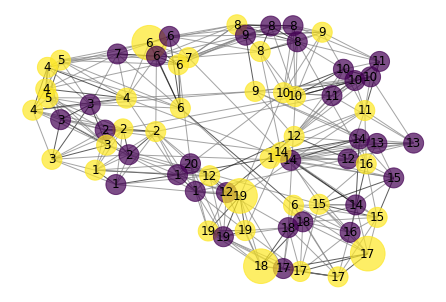

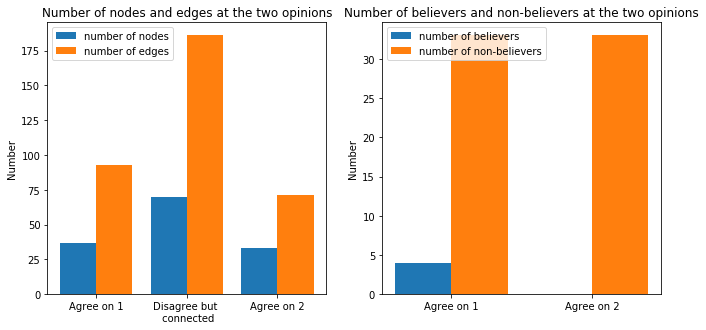

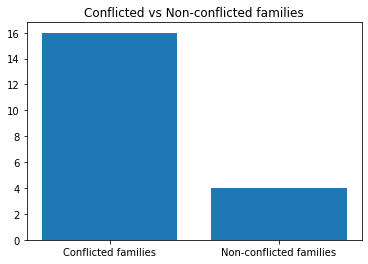

In [3]:
my_network = family_network(gamma=4, family_gamma=1.1, beta=0.3, believers = 1, media =2)
my_network.set_inits()
my_network.observe()
my_network.make_plot('bar')

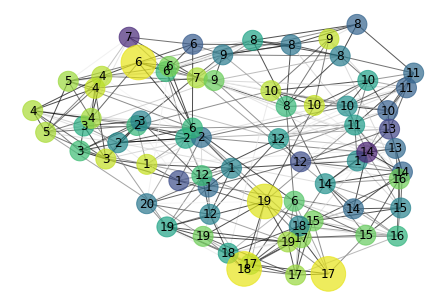

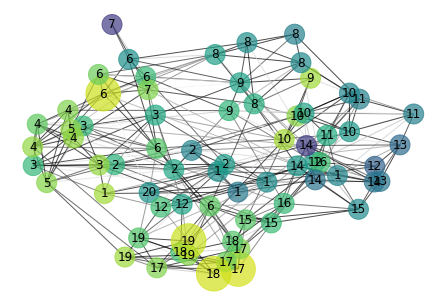

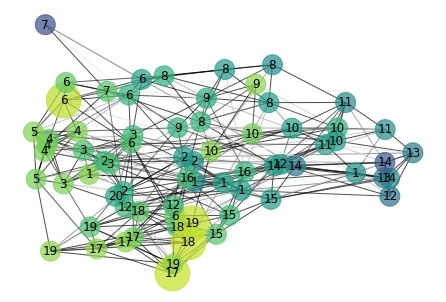

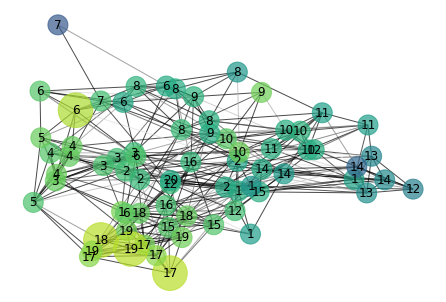

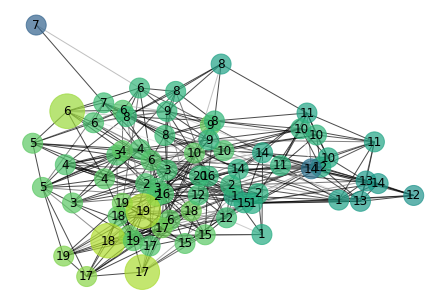

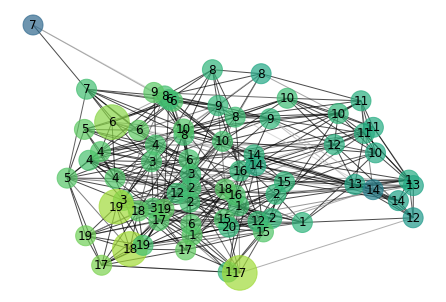

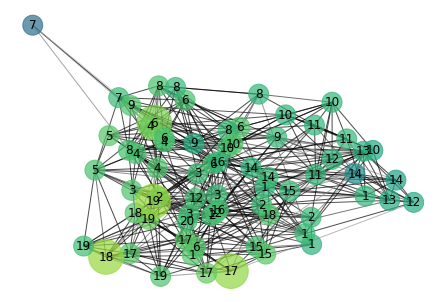

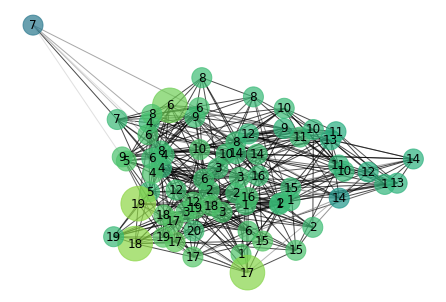

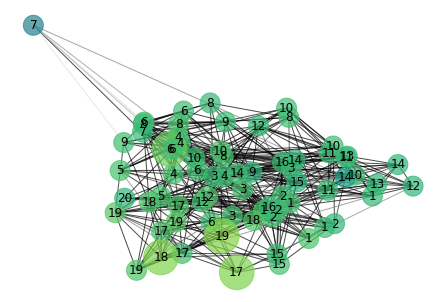

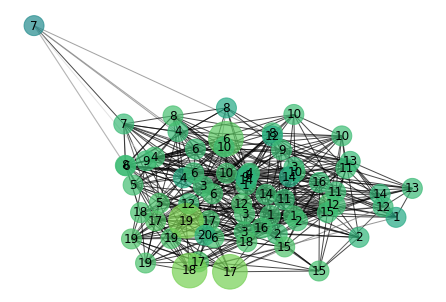

In [4]:
for i in range(10):
    for i in range(2000):
        my_network.update()
    #plt.figure()
    my_network.observe()



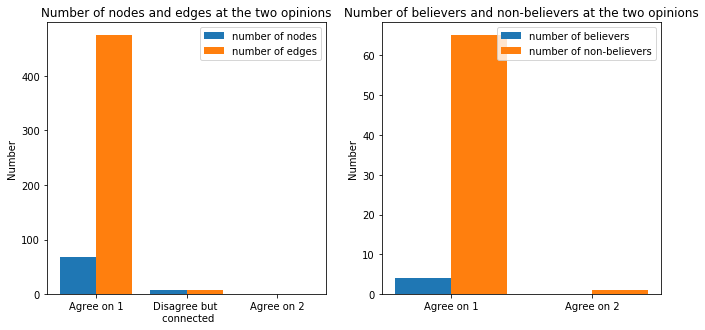

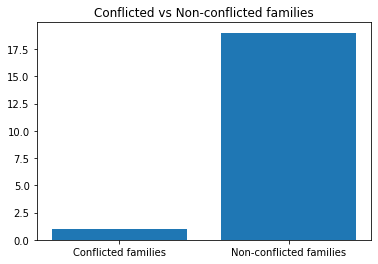

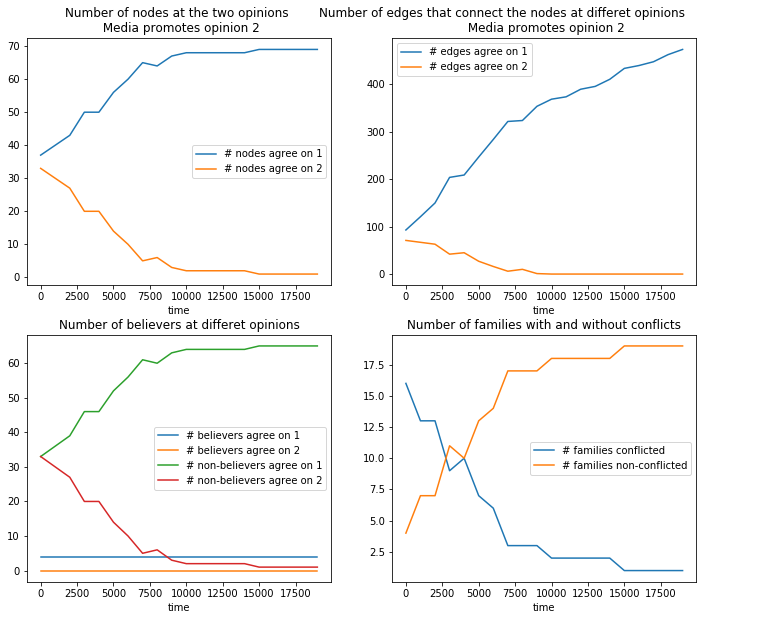

In [5]:
my_network.make_plot('bar')
my_network.make_plot('linear')

In [6]:
#this function will calculate percentatges:
def averager(gamma, family_gamma, beta, believers , media):
    iterations = 100
    opinion_1_counter=  0
    opinion_2_counter = 0
    conflicted_family = 0
    

    for i in range(iterations):
        my_network = family_network(gamma, family_gamma, beta, believers , media )
        my_network.set_inits()
        for j in range(10):
            for m in range(2000):
                my_network.update()
        
        #number of times that convergence favors opinion 1 over 2
        if my_network.len_similar_nodes_1[-1] > my_network.len_similar_nodes_2[-1]:
            opinion_1_counter+=1
        else:
            opinion_2_counter+=1
        #counting the number of conflicted families after each iteration
        conflicted_family+=my_network.len_conflicted_families[-1]
        
    return opinion_1_counter/iterations, opinion_2_counter/iterations, conflicted_family/iterations


In [7]:
results = averager(gamma=4, family_gamma=1.1, beta=0.3, believers = 1, media =2)
print("opinion 1 convergence times:", results[0])
print("opinion 2 convergence times:", results[1])

opinion 1 convergence times: 0.72
opinion 2 convergence times: 0.28


In [8]:
results2 = averager(gamma=4, family_gamma=4, beta=0.3, believers = False, media =False)
print("average conflicted families with gamma=4:", results2[-1])

average conflicted families with gamma=4: 5.34


In [9]:
results2 = averager(gamma=4, family_gamma=1.1, beta=0.3, believers = False, media =False)
print("average conflicted families with gamma=1.1:", results2[-1])

average conflicted families with gamma=1.1: 3.27


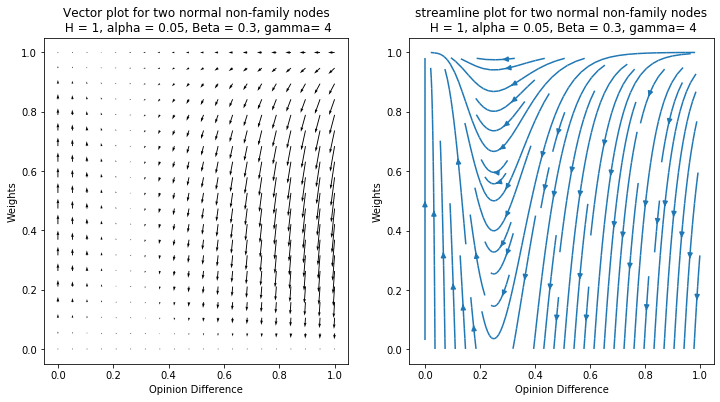

In [10]:
# create vector field plots and streamline plots
alpha = 0.05
beta = 0.3
gamma = 4
H = 1

x = y = np.linspace(0, 1, 20)
x_grid, y_grid = np.meshgrid(x, y)

vector_x = -H*alpha*y_grid*x_grid #H*alhpa * weight*opinion difference
vector_y = beta*y_grid *(1-y_grid) *(1-gamma*x_grid)

plt.subplots(1, 2, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.quiver(x_grid, y_grid, vector_x, vector_y)
plt.xlabel('Opinion Difference')
plt.ylabel('Weights')
plt.title(f"Vector plot for two normal non-family nodes\n H = {H}, alpha = {alpha}, Beta = {beta}, gamma= {gamma}")

#
plt.subplot(1, 2, 2)
plt.streamplot(x_grid, y_grid, vector_x, vector_y)
plt.xlabel('Opinion Difference')
plt.ylabel('Weights')
plt.title(f"streamline plot for two normal non-family nodes\n H = {H}, alpha = {alpha}, Beta = {beta}, gamma= {gamma}")
plt.show()

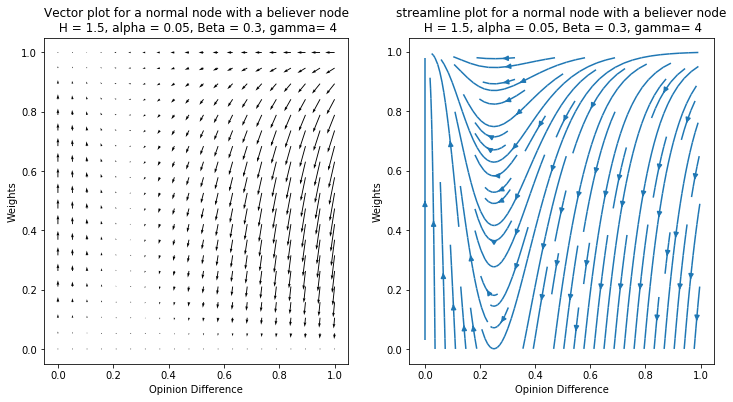

In [11]:
# create vector field plots and streamline plots
alpha = 0.05
beta = 0.3
gamma = 4
H = 1.5


x = y = np.linspace(0, 1, 20)
x_grid, y_grid = np.meshgrid(x, y)

vector_x = -H*alpha*y_grid*x_grid #H*alhpa * weight*opinion difference
vector_y = beta*y_grid *(1-y_grid) *(1-gamma*x_grid)

plt.subplots(1, 2, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.quiver(x_grid, y_grid, vector_x, vector_y)
plt.xlabel('Opinion Difference')
plt.ylabel('Weights')
plt.title(f"Vector plot for a normal node with a believer node\n H = {H}, alpha = {alpha}, Beta = {beta}, gamma= {gamma}")

#
plt.subplot(1, 2, 2)
plt.streamplot(x_grid, y_grid, vector_x, vector_y)
plt.xlabel('Opinion Difference')
plt.ylabel('Weights')
plt.title(f"streamline plot for a normal node with a believer node\n H = {H}, alpha = {alpha}, Beta = {beta}, gamma= {gamma}")
plt.show()

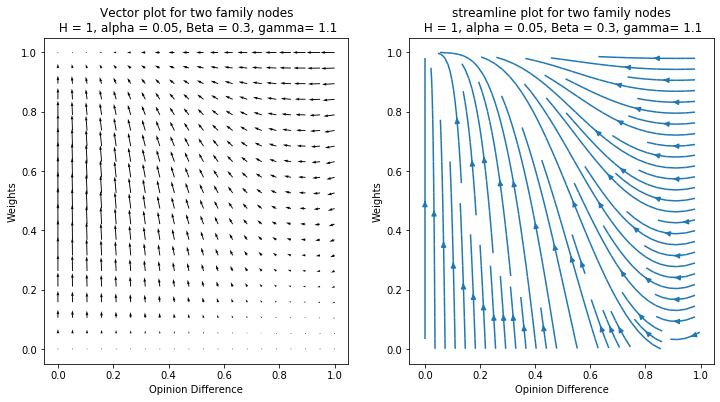

In [12]:
# create vector field plots and streamline plots
alpha = 0.05
beta = 0.3
gamma = 1.1
H = 1


x = y = np.linspace(0, 1, 20)
x_grid, y_grid = np.meshgrid(x, y)

vector_x = -H*alpha*y_grid*x_grid #H*alhpa * weight*opinion difference
vector_y = beta*y_grid *(1-y_grid) *(1-gamma*x_grid)

plt.subplots(1, 2, figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.quiver(x_grid, y_grid, vector_x, vector_y)
plt.xlabel('Opinion Difference')
plt.ylabel('Weights')
plt.title(f"Vector plot for two family nodes\n H = {H}, alpha = {alpha}, Beta = {beta}, gamma= {gamma}")

#
plt.subplot(1, 2, 2)
plt.streamplot(x_grid, y_grid, vector_x, vector_y)
plt.xlabel('Opinion Difference')
plt.ylabel('Weights')
plt.title(f"streamline plot for two family nodes\n H = {H}, alpha = {alpha}, Beta = {beta}, gamma= {gamma}")
plt.show()